Texas power forecast project

In [1]:
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator, ConciseDateFormatter
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

import itertools
#from pmdarima import auto_arima

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import GridSearchCV

%matplotlib inline

# Exploring 

In [2]:
! ls ../Data/texasPowerGrid.csv

../Data/texasPowerGrid.csv


In [3]:
texas = pd.read_csv('../Data/texasPowerGrid.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (11,12,23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
texas.set_index(pd.to_datetime(texas['UTC Time at End of Hour']), inplace=True)
texas

,Unnamed: 0,Balancing Authority,Data Date,Hour Number,Local Time at End of Hour,UTC Time at End of Hour,Demand Forecast (MW),Demand (MW),Net Generation (MW),Total Interchange (MW),...,Region,Net Generation (MW) from Coal,Net Generation (MW) from Natural Gas,Net Generation (MW) from Nuclear,Net Generation (MW) from All Petroleum Products,Net Generation (MW) from Hydropower and Pumped Storage,Net Generation (MW) from Solar,Net Generation (MW) from Wind,Net Generation (MW) from Other Fuel Sources,Net Generation (MW) from Unknown Fuel Sources
UTC Time at End of Hour,,,,,,,,,,,,,,,,,,,,,
2018-01-01 07:00:00,65148,ERCO,01/01/2018,1,01/01/2018 1:00:00 AM,01/01/2018 7:00:00 AM,"47,834","50,587","50,800",212,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 08:00:00,65149,ERCO,01/01/2018,2,01/01/2018 2:00:00 AM,01/01/2018 8:00:00 AM,"48,313","50,650","51,036",385,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 09:00:00,65150,ERCO,01/01/2018,3,01/01/2018 3:00:00 AM,01/01/2018 9:00:00 AM,"49,513","50,737","50,887",150,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 10:00:00,65151,ERCO,01/01/2018,4,01/01/2018 4:00:00 AM,01/01/2018 10:00:00 AM,"48,663","51,021","51,419",398,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 11:00:00,65152,ERCO,01/01/2018,5,01/01/2018 5:00:00 AM,01/01/2018 11:00:00 AM,"50,639","51,727","52,048",321,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-06 02:00:00,56839,ERCO,12/05/2022,20,12/05/2022 8:00:00 PM,12/06/2022 2:00:00 AM,"45,525",NaN,NaN,NaN,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-06 03:00:00,56840,ERCO,12/05/2022,21,12/05/2022 9:00:00 PM,12/06/2022 3:00:00 AM,"44,590",NaN,NaN,NaN,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-06 04:00:00,56841,ERCO,12/05/2022,22,12/05/2022 10:00:00 PM,12/06/2022 4:00:00 AM,"43,224",NaN,NaN,NaN,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
texas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43200 entries, 2018-01-01 07:00:00 to 2022-12-06 06:00:00
Data columns (total 25 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Unnamed: 0                                              43200 non-null  int64  
 1   Balancing Authority                                     43200 non-null  object 
 2   Data Date                                               43200 non-null  object 
 3   Hour Number                                             43200 non-null  int64  
 4   Local Time at End of Hour                               43200 non-null  object 
 5   UTC Time at End of Hour                                 43200 non-null  object 
 6   Demand Forecast (MW)                                    43104 non-null  object 
 7   Demand (MW)                                             43080 non-null  object 
 8   N

most of columns are object type, might be because of null values, will further look into each of columns

## Unamed

In [ ]:
#old index
texas['Unnamed: 0']

will drop column, was index before we set datetime index

In [ ]:
texas.drop(columns='Unnamed: 0', inplace=True)

## Balancing Authority 

In [ ]:
texas['Balancing Authority'].unique()

will drop column, it has only a single value

In [ ]:
texas.drop(columns='Balancing Authority', inplace=True)

## Data Date 

In [ ]:
texas['Data Date']

In [ ]:
texas['Hour Number']

In [ ]:
texas['Local Time at End of Hour']

In [ ]:
texas['UTC Time at End of Hour']

those 4 columns display datetime data, not necessary since we already have a datetime index, will drop them

In [ ]:
date_columns = ['Data Date', 'Hour Number', 'Local Time at End of Hour', 'UTC Time at End of Hour']
texas.drop(columns=date_columns, inplace=True)


## Total Interchange (MW)

In [6]:
texas['Total Interchange (MW)'] 

UTC Time at End of Hour
2018-01-01 07:00:00    212
2018-01-01 08:00:00    385
2018-01-01 09:00:00    150
2018-01-01 10:00:00    398
2018-01-01 11:00:00    321
                      ... 
2022-12-06 02:00:00    NaN
2022-12-06 03:00:00    NaN
2022-12-06 04:00:00    NaN
2022-12-06 05:00:00    NaN
2022-12-06 06:00:00    NaN
Name: Total Interchange (MW), Length: 43200, dtype: object

will convert from object to float

In [7]:
texas['Total Interchange (MW)'] = texas['Total Interchange (MW)'].str.replace(',', '').astype(float)
texas['Total Interchange (MW)']

UTC Time at End of Hour
2018-01-01 07:00:00    212.0
2018-01-01 08:00:00    385.0
2018-01-01 09:00:00    150.0
2018-01-01 10:00:00    398.0
2018-01-01 11:00:00    321.0
                       ...  
2022-12-06 02:00:00      NaN
2022-12-06 03:00:00      NaN
2022-12-06 04:00:00      NaN
2022-12-06 05:00:00      NaN
2022-12-06 06:00:00      NaN
Name: Total Interchange (MW), Length: 43200, dtype: float64

In [8]:
texas['Total Interchange (MW)'].isna().sum()

125

In [9]:
texas.dropna(subset=['Total Interchange (MW)'], inplace=True)

In [10]:
texas['Total Interchange (MW)'].isna().sum()

0

Interchange is the target, will do exploration on this columns

## Interchange

<AxesSubplot:xlabel='UTC Time at End of Hour'>

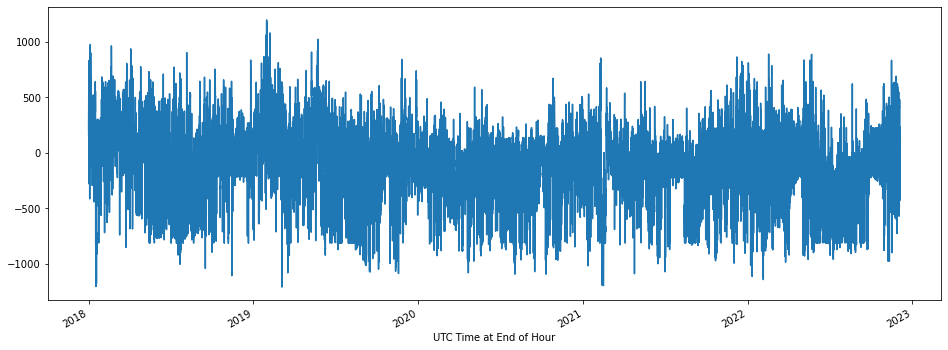

In [11]:
inter = texas['Total Interchange (MW)']
inter.plot(figsize=(16,6))

In [ ]:
dftest = adfuller(inter)
display(dftest)

Not stationary
will try make stationary to perform Arima

### Interchange check individual years

In [70]:
len(inter)

43075

In [69]:
inter['2020-02-28':'2020-03-01']

UTC Time at End of Hour
2020-02-28 00:00:00   -216.0
2020-02-28 01:00:00   -120.0
2020-02-28 02:00:00    -44.0
2020-02-28 03:00:00    -90.0
2020-02-28 04:00:00    -89.0
                       ...  
2020-03-01 19:00:00   -144.0
2020-03-01 20:00:00     -2.0
2020-03-01 21:00:00      2.0
2020-03-01 22:00:00     44.0
2020-03-01 23:00:00    102.0
Name: Total Interchange (MW), Length: 72, dtype: float64

In [64]:
inter.resample('D').mean()

UTC Time at End of Hour
2018-01-01    285.352941
2018-01-02    452.625000
2018-01-03      4.333333
2018-01-04    275.041667
2018-01-05    519.625000
                 ...    
2022-12-01     78.375000
2022-12-02     17.916667
2022-12-03     11.041667
2022-12-04    -20.458333
2022-12-05      5.571429
Freq: D, Name: Total Interchange (MW), Length: 1800, dtype: float64

In [67]:
year_groups.groups

{Timestamp('2018-12-31 00:00:00', freq='A-DEC'): 365,
 Timestamp('2019-12-31 00:00:00', freq='A-DEC'): 730,
 Timestamp('2020-12-31 00:00:00', freq='A-DEC'): 1096,
 Timestamp('2021-12-31 00:00:00', freq='A-DEC'): 1461,
 Timestamp('2022-12-31 00:00:00', freq='A-DEC'): 1800}

In [59]:
year_groups = inter.resample('D').mean().groupby(pd.Grouper(freq='A'))
year_groups

In [60]:
# Create a new DataFrame and store yearly values in columns 
inter2 = pd.DataFrame()

for yr, group in year_groups:
    inter2[yr.year] = group.values.ravel()


# Plot the yearly groups as subplots
inter2.plot(figsize = (13,8), subplots=True, legend=True);

ValueError: Length of values (366) does not match length of index (365)

In [ ]:
inter2.plot(figsize = (13,8), subplots=False, legend=True);

interchange gets higher negative values between june and august, supply not enough for demand most likely due to AC usage during summer season

In [ ]:
inter2.boxplot(figsize = (12,7));

interchange value mean gets lower into the negative numbers every year, doesnt seem to be many outliers to handle

Sometimes the distribution of the values is important.

What are some reasons?

Checking for normality (for stat testing)


First check on raw data

In [ ]:
inter.hist()

In [ ]:
inter.plot(kind='kde', figsize = (15,10));

bit skew to the left, more negatives

In [ ]:
rolling_avg_ts = inter.rolling(window=24).mean()


In [ ]:
differenced_ts = inter - rolling_avg_ts
differenced_ts.dropna(inplace=True)
differenced_transformed_ts = np.sqrt(inter) - np.sqrt(rolling_avg_ts)
differenced_transformed_ts.dropna(inplace=True)

fig, axes = plt.subplots(ncols=3, figsize=(16,4))

axes[0].plot(inter, color="gray", label="Daily energy use", )
axes[0].plot(rolling_avg_ts, color="blue", label="7-day moving average")
axes[1].plot(differenced_ts, color="green", label="Differenced")
axes[2].plot(differenced_transformed_ts, label="Differenced and transformed")

locator = AutoDateLocator()
formatter = ConciseDateFormatter(locator)

for ax in axes:
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.legend()

Log tranform

In [ ]:
log_tran = np.log(inter)
log_tran.plot();

Subtracting the rolling mean

In [ ]:
roll_mean = inter.rolling(window=4).mean()
fig = plt.figure(figsize=(16,6))
plt.plot(inter, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
data_minus_roll_mean = inter - roll_mean
data_minus_roll_mean.head(15)

In [ ]:
# Drop the missing values from time series calculated above
data_minus_roll_mean.dropna(inplace=True)

In [ ]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_roll_mean, color='blue',label='-')
plt.legend(loc='best')
plt.title('-')
plt.show(block=False)

In [ ]:
dftest1 = adfuller(data_minus_roll_mean)
display(dftest1)

seems like it worked, substracting the rollig mean got us an stationary set, will try differencing since it can be useful to remove seasonality

In [ ]:
data_diff = inter.diff(periods=1)
data_diff.head(10)

In [ ]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

In [12]:
cutoff = round(inter.shape[0]*0.8)
cutoff

train = inter[:cutoff]

test = inter[cutoff:]

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [ ]:
# ### Import Packages ###
# import itertools
# import statsmodels.api as sm

# ### Define Parameter Ranges to Test ###
# # Note: higher numbers will result in code taking much longer to run
# # Here we have it set to test p,d,q each = 0, 1 & 2
# # Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
# p = d = q = range(0, 3)
# # Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))
# # Generate all different combinations of seasonal p, q and q triplets
# # Note: here we have 12 in the ‘s’ position as we have monthly data
# # You’ll want to change this according to your time series’ frequency
# pdqs = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
# ### Run Grid Search ###
# # Note: this code will take a while to run
# # Define function
# def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='H'):
#     '''
#     Input:
#         ts : your time series data
#         pdq : ARIMA combinations from above
#         pdqs : seasonal ARIMA combinations from above
#         maxiter : number of iterations, increase if your model isn’t converging
#         frequency : default=‘M’ for month. Change to suit your time series frequency
#             e.g. ‘D’ for day, ‘H’ for hour, ‘Y’ for year.
#     Return:
#         Prints out top 5 parameter combinations
#         Returns dataframe of parameter combinations ranked by BIC
#     '''
#     # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
#     ans = []
#     for comb in pdq:
#         for combs in pdqs:
#             try:
#                 mod = sm.SARIMAX(ts, # this is your time series you will input
#                                                 order=comb,
#                                                 seasonal_order=combs,
#                                                 enforce_stationarity=False,
#                                                 enforce_invertibility=False,
#                                                 freq=freq)
#                 output = mod.fit(maxiter=maxiter)
#                 ans.append([comb, combs, output.bic])
#                 print('SARIMAX {} x {}12 :  bic Calculated ={}'.format(comb, combs, output.bic))
#             except:
#                 continue
#     # Find the parameters with minimal BIC value
#     # Convert into dataframe
#     ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])
#     # Sort and return top 5 combinations
#     ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
#     return ans_df
# ### Apply function to your time series data ###
# # Remember to change frequency to match your time series data
# # sarimax_gridsearch(train, pdq, pdqs, freq='H')

## Grid search

In [13]:
import statsmodels.api as sm
import itertools

In [14]:
import statsmodels.api as sm
import itertools
# Grid Search
p = d = q = range(0,3) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q 
p2 = d2 = q2 = range(0, 2) # second set of p's, d's, and q's
pdq2 = list(itertools.product(p2,d2,q2)) # simular too code above but for seasonal parameters
s = 24 # here I use twelve but the number here is representative of the periodicty of the seasonal cycle
pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]
combs = {}
bics = []
# Grid Search Continued
for combination in pdq:
    for seasonal_combination in pdqs2:
        try:
            model = sm.tsa.statespace.SARIMAX(train, order=combination, seasonal_order=seasonal_combination,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            model = model.fit()
            combs.update({model.bic : [combination, seasonal_combination]})
            bics.append(model.bic)
            
        except:
            continue
            
best_bic = min(bics)
# Modeling and forcasting
model = sm.tsa.statespace.SARIMAX(train, order=combs[best_bic][0], seasonal_order=combs[best_bic][1],
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
model = model.fit()
model.forecast(7)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction resul

34460    1.295160e+07
34461    1.295301e+07
34462    1.295444e+07
34463    1.295590e+07
34464    1.295733e+07
34465    1.295876e+07
34466    1.296023e+07
Name: predicted_mean, dtype: float64

In [15]:
best_bic

224478.39108868482

In [20]:
len(bics)

216

In [18]:
combs

{496336.32172734506: [(0, 0, 0), (0, 0, 0, 24)],
 486599.7865858887: [(0, 0, 0), (0, 0, 1, 24)],
 489195.94147108117: [(0, 0, 0), (0, 1, 0, 24)],
 479196.81360228645: [(0, 0, 0), (0, 1, 1, 24)],
 481303.3814671283: [(0, 0, 0), (1, 0, 0, 24)],
 478586.9016861344: [(0, 0, 0), (1, 0, 1, 24)],
 483963.27097789233: [(0, 0, 0), (1, 1, 0, 24)],
 477243.45869847486: [(0, 0, 0), (1, 1, 1, 24)],
 465787.48743042076: [(0, 0, 1), (0, 0, 0, 24)],
 459117.5032887481: [(0, 0, 1), (0, 0, 1, 24)],
 465558.81190454686: [(0, 0, 1), (0, 1, 0, 24)],
 453220.9445531003: [(0, 0, 1), (0, 1, 1, 24)],
 455875.1010930189: [(0, 0, 1), (1, 0, 0, 24)],
 452858.37292400864: [(0, 0, 1), (1, 0, 1, 24)],
 459348.35837247013: [(0, 0, 1), (1, 1, 0, 24)],
 451802.0332502275: [(0, 0, 1), (1, 1, 1, 24)],
 457153.13538177096: [(0, 0, 2), (0, 0, 0, 24)],
 447063.4874030623: [(0, 0, 2), (0, 0, 1, 24)],
 456718.52306830365: [(0, 0, 2), (0, 1, 0, 24)],
 442359.13985693787: [(0, 0, 2), (0, 1, 1, 24)],
 445205.0050699825: [(0, 0, 

In [ ]:
# 224478.39108868482: [(1, 2, 2), (0, 1, 1, 24)],

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:               Total Interchange (MW)   No. Observations:                34460
Model:             SARIMAX(1, 2, 2)x(0, 1, [1], 24)   Log Likelihood             -112213.081
Date:                              Wed, 07 Dec 2022   AIC                         224436.161
Time:                                      07:32:04   BIC                         224478.391
Sample:                                           0   HQIC                        224449.623
                                            - 34460                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8772      0.006    152.298      0.000       0.866       0.889
ma.L1         -1.9982   1.16e-07  -1.73e+07      0.000      -1.998      -1.998
ma.L2          0.9982   4.21e-08   2.37e+07      0.000       0.998       0.998
ma.S.L24      -0.9286   2.64e-05  -3.51e+04      0.000      -0.929      -0.929
sigma2      3.214e+04   1.66e-08   1.94e+12      0.000    3.21e+04    3.21e+04
===================================================================================
Ljung-Box (L1) (Q):                  69.07   Jarque-Bera (JB):            109090.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.53e+26. Standard errors may be unstable.
"""

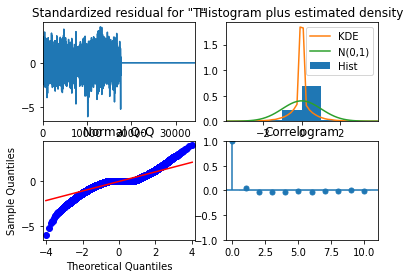

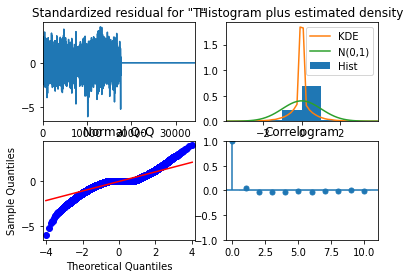

In [78]:
model.plot_diagnostics()

In [ ]:
# 224478.39108868482: [(1, 2, 2), (0, 1, 1, 24)],

In [88]:
trainD = train.resample('MS').mean()
testD = test.resample('MS').mean()


model2 = sm.tsa.statespace.SARIMAX(trainD, order=(1, 2, 2), seasonal_order=(0, 1, 1, 12),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
model2 = model2.fit()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [89]:
y_hat_train = model2.predict(typ='levels')

In [90]:
y_hat_test = model2.predict(start='2021-12-11', end='2022-12-05', typ='levels')

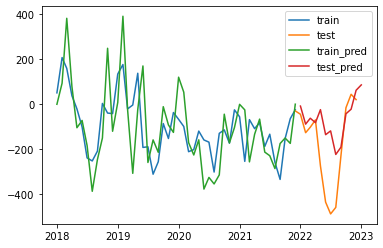

In [92]:
fig, ax = plt.subplots()
ax.plot(trainD, label='train')
ax.plot(testD, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

960x0.jpg                  Dallas_Weather.csv
Amarillo_Weather.csv       El_Paso_Weather.csv
Corpus_Christi_Weather.csv texasPowerGrid.csv


In [ ]:
# split = TimeSeriesSplit()

In [ ]:
# train.isna().sum()

In [ ]:
# naive = train.shift(1)
# naive

In [ ]:
# fig, ax = plt.subplots()

# train[0:30].plot(ax=ax, c='r', label='original')
# naive[0:30].plot(ax=ax, c='b', label='shifted')
# ax.set_title('naive')
# ax.legend();

In [ ]:
# np.sqrt(mean_squared_error(train[1:], naive.dropna()))

In [ ]:
# fig, ax = plt.subplots(figsize = (16,6))
# residuals = naive[1:] - train[1:]
# ax.plot(residuals.index, residuals)
# ax.plot(residuals.index, residuals.rolling(30).std());

In [ ]:
# fig, ax = plt.subplots(figsize = (16,6))

# ax.plot(residuals.index, residuals.rolling(6).var());